In [1]:
# import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras


# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Reshape, LSTM, Dropout, Activation 
from keras.layers import Conv1D, MaxPooling1D, Embedding, Concatenate, AveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten
from keras.layers import GlobalMaxPooling2D, Conv3D, MaxPooling3D, ConvLSTM2D, Add
from keras.models import Model
from keras.initializers import Constant
import tensorflow as tf

import pickle


2024-04-27 20:16:14.878087: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 20:16:14.878174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 20:16:15.007093: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Added Some Batch norm in Audio part and Activation layer in Frame part**

# TEXT SECTION OF THE MODEL

In [ ]:
MAX_UTTERANCE_LENGTH = 20
MAX_NUM_WORDS = 20000

In [ ]:
#Load the data
pickle_text = open("X_dev_text_utterances.pickle","rb")
X_dev_text_utterances = pickle.load(pickle_text)

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\x97\x92\x98\x85\x91')
tokenizer.fit_on_texts(X_dev_text_utterances)
X_dev_text_sequences = tokenizer.texts_to_sequences(X_dev_text_utterances)
X_dev_data_text = pad_sequences(X_dev_text_sequences, maxlen=MAX_UTTERANCE_LENGTH)

In [ ]:
X_dev_data_text.shape  # <---- This is the data to be fed as input to the NN

In [12]:
X_dev_embedding_matrix = open("X_dev_embedding.pickle","rb")
X_dev_embedding_matrix = pickle.load(X_dev_embedding_matrix)

In [13]:
num_words = len(X_dev_embedding_matrix)
EMBEDDING_DIM = X_dev_embedding_matrix.shape[1]

In [14]:
print(num_words)

1482


In [15]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(X_dev_embedding_matrix),
                            input_length=MAX_UTTERANCE_LENGTH,
                            trainable=False)

In [16]:
input_text_ = Input(shape = (MAX_UTTERANCE_LENGTH,), dtype = 'int32')
embedded_sequences = embedding_layer(input_text_)
output_text_ = Conv1D(64, 5, activation='relu')(embedded_sequences)
output_text_ = MaxPooling1D(2)(output_text_)
output_text_ = Conv1D(100, 5, activation='relu')(output_text_)
output_text_ = GlobalMaxPooling1D()(output_text_) #as in paper 100D textual features

model_text = Model(inputs = input_text_, outputs = output_text_)
model_text.summary()

Model: "model_2"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


input_3 (InputLayer)         (None, 20)                0         

_________________________________________________________________

embedding_2 (Embedding)      (None, 20, 300)           444600    

_________________________________________________________________

conv1d_5 (Conv1D)            (None, 16, 64)            96064     

_________________________________________________________________

max_pooling1d_3 (MaxPooling1 (None, 8, 64)             0         

_________________________________________________________________

conv1d_6 (Conv1D)            (None, 4, 100)            32100     

_________________________________________________________________

global_max_pooling1d_3 (Glob (None, 100)               0         


Total params: 572,764

Trainable params: 128,164

Non-trainable params: 444,600

____________________________

# FRAME SECTION OF THE MODEL

In [3]:
import mmap

In [4]:
#Load frame data
# X_dev_frame_float32 = np.load('/kaggle/input/ravdess-av-data/Video_data_10.npz')
# X_dev_frame_float32_ = X_dev_frame_float32['arr_0']
with open("/kaggle/input/ravdess-av-data/Video_data10.pickle","rb") as f:
    mm = mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)
    unpickler = pickle.Unpickler(mm)
    X_dev_frame_float32 = unpickler.load()
#     X_dev_frame_float32 = pickle.load(f)
# X_dev_frame_float32 = pickle.load(pickle_frame)

# Normalize Image
# X_dev_frame_float32_ = tf.convert_to_tensor(X_dev_frame_float32, dtype = tf.float64)

In [4]:
! ls ../input/

Audio_data_test.pickle	 Output_data_test.pickle   Video_data_test_10.npz
Audio_data_train.pickle  Output_data_train.pickle  Video_data_train_10.npz


In [16]:
import os
for root, folder, filename in os.walk('../input/'):
    print(root, folder)

../input/ []


In [2]:
X_dev_frame_float32 = np.load('../input/Video_data_train_10.npz', mmap_mode='r+')
X_dev_frame_float32['arr_0'].shape 

(1008, 10, 224, 400, 1)

In [3]:
X_dev_frame_float32 = X_dev_frame_float32['arr_0'].astype("float64")
X_dev_frame_float32 = X_dev_frame_float32 / 255
# X_dev_frame_float32 = tf.convert_to_tensor(X_dev_frame_float32, dtype = tf.float64)

In [4]:
input_frame_ = Input(shape = (10, 224, 400, 1))

output_frame_ = ConvLSTM2D(filters=16, kernel_size=(3, 3),
                   padding='valid', return_sequences=False)(input_frame_) 
output_frame_ = BatchNormalization()(output_frame_)
output_frame_ = Activation('relu')(output_frame_)
output_frame_ = MaxPooling2D((2, 2), strides = 2)(output_frame_)

output_frame_ = Conv2D(32, kernel_size=(3, 3))(output_frame_)
output_frame_ = BatchNormalization()(output_frame_)
output_frame_ = Activation('relu')(output_frame_)
output_frame_ = MaxPooling2D((2, 2))(output_frame_)

output_frame_ = Conv2D(64, kernel_size=(3, 3))(output_frame_)
output_frame_ = BatchNormalization()(output_frame_)
output_frame_ = Activation('relu')(output_frame_)
output_frame_ = MaxPooling2D((2, 2))(output_frame_)

# output_frame_ = Conv2D(64, kernel_size=(3, 3))(output_frame_)
# output_frame_ = BatchNormalization()(output_frame_)
# output_frame_ = Activation('relu')(output_frame_)
# output_frame_ = MaxPooling2D((2, 2))(output_frame_)

output_frame_ = Conv2D(16, kernel_size=(3, 3))(output_frame_)
output_frame_ = BatchNormalization()(output_frame_)
output_frame_ = Activation('relu')(output_frame_)
# output_frame_ = MaxPooling2D((2, 2))(output_frame_)

output_frame_ = Flatten()(output_frame_)

# model = Model(inputs = [input_frame_], outputs = output_frame_)
# model.summary()

# AUDIO SECTION OF THE MODEL

In [5]:
pickle_audio_mfcc = open("../input/Audio_data_train.pickle","rb")
X_dev_audio_mfcc = pickle.load(pickle_audio_mfcc)

In [6]:
X_dev_audio_mfcc = X_dev_audio_mfcc[:, :, :-128] ## Taking only MFCC 

In [7]:
X_dev_audio_mfcc.shape

(1008, 100, 25)

In [3]:
import numpy as np

a = np.array([1, 2, 3, 4, 5, 6])

a[:-6]
153 - 128

25

In [8]:
input_audio_ = Input(shape = (100, 25))
print(input_audio_.shape)
output_audio_ = Conv1D(16, 3)(input_audio_)
output_audio_ = BatchNormalization()(output_audio_)
output_audio_ = Activation('relu')(output_audio_)

output_audio_ = MaxPooling1D(2)(output_audio_)

output_audio_ = Conv1D(32, 3)(output_audio_)
output_audio_ = BatchNormalization()(output_audio_)
output_audio_ = Activation('relu')(output_audio_)

output_audio_ = MaxPooling1D(2)(output_audio_)

output_audio_ = Reshape((32 * 23,))(output_audio_)
# model_audio = Model(inputs = input_audio_, outputs = output_audio_)
# model_audio.summary()

(None, 100, 25)
(None, 98, 16)
(None, 49, 16)
(None, 47, 32)
(None, 23, 32)


# Concatenate Model

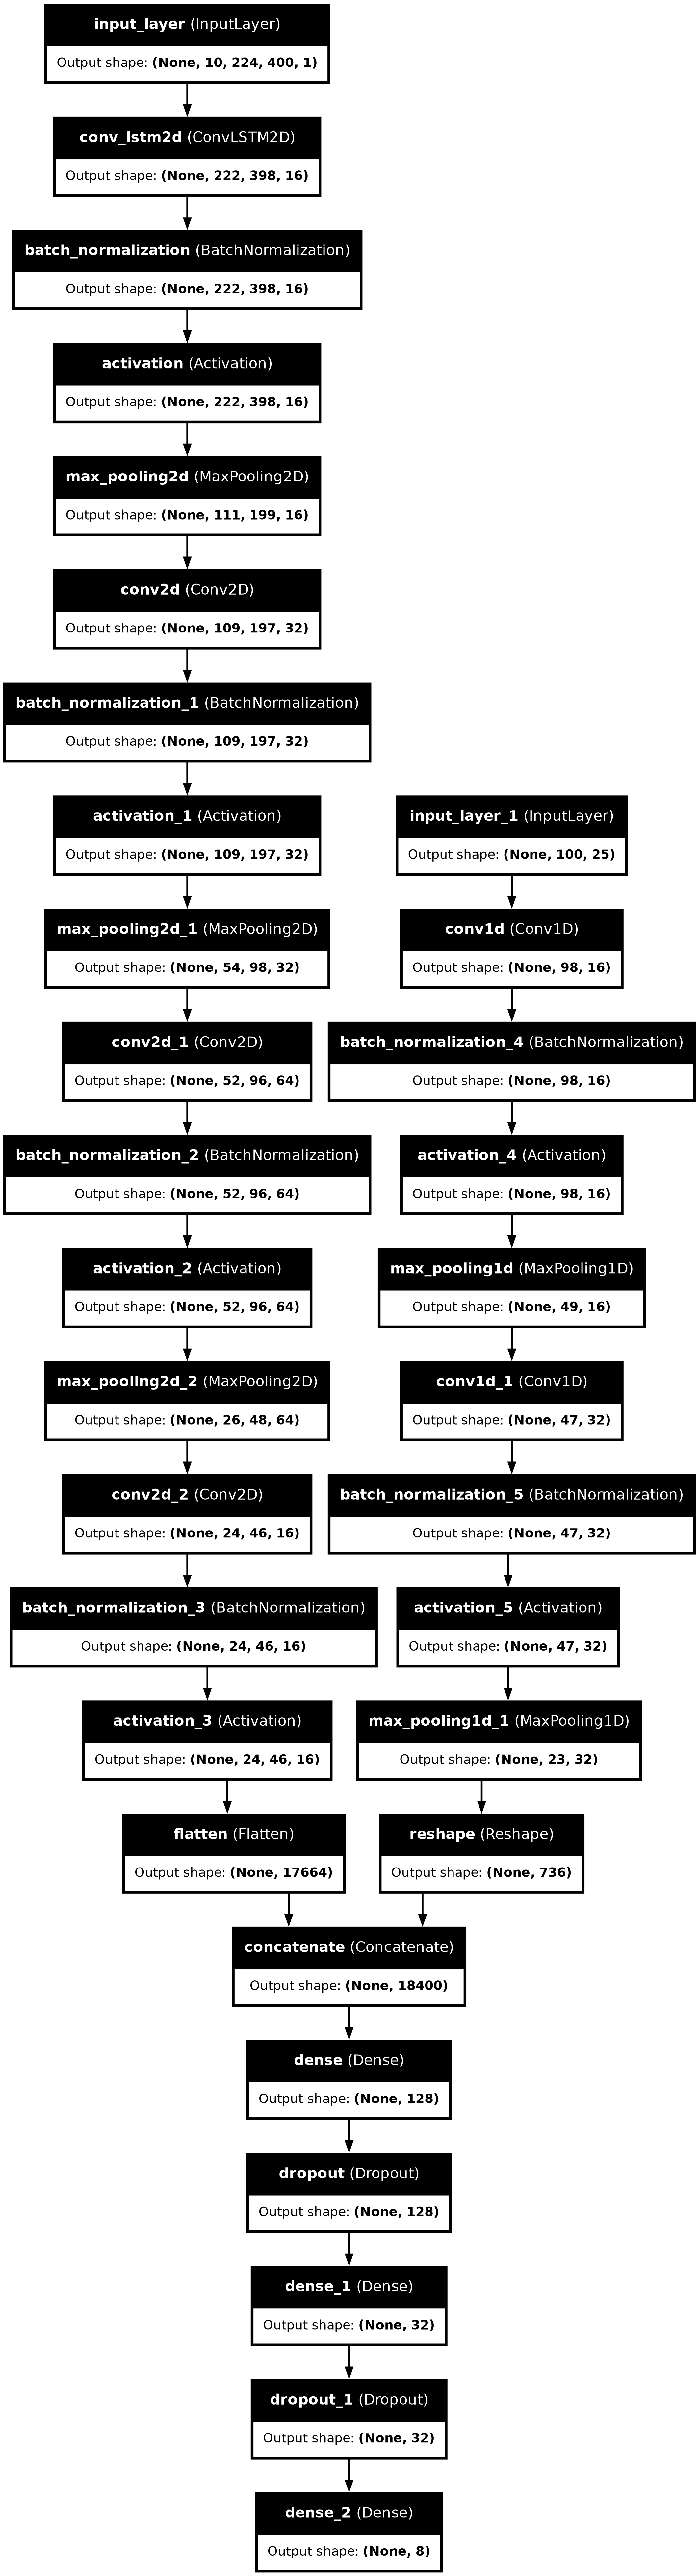

In [9]:
#Now concatenate all the layers to make a multimodal
concatenate = Concatenate()([output_frame_, output_audio_])
concatenate = Dense(128, activation='relu')(concatenate)
concatenate = Dropout(rate= 0.5)(concatenate)
concatenate_ = Dense(32, activation='relu')(concatenate)
concatenate_ = Dropout(rate= 0.5)(concatenate_)
y_predict_emotions = Dense(8, activation='softmax')(concatenate_)
# y_predict_sentiments = Dense(3, activation='softmax')(concatenate)
model = Model(inputs=[input_frame_, input_audio_], outputs=[y_predict_emotions])
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [10]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 224,   │          0 │ -                 │
│ (InputLayer)        │ 400, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d         │ (None, 222, 398,  │      9,856 │ input_layer[0][0] │
│ (ConvLSTM2D)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 222, 398,  │         64 │ conv_lstm2d[0][0] │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 222, 398,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 111, 199,  │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 109, 197,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 197,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 197,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 100, 25)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 54, 98,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 98, 16)    │      1,216 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 52, 96,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 98, 16)    │         64 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 96,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 98, 16)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 52, 96,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 49, 16)    │          0 │ activation_4[0][… │
│ (MaxPooling1D)      │                   │            │                 

 Total params: 2,405,432 (9.18 MB)

 Trainable params: 2,405,080 (9.17 MB)

 Non-trainable params: 352 (1.38 KB)

# Y_prediction:  Label section of the model

In [11]:
pickle_y_dev = open("../input/Output_data_train.pickle","rb")
Y_dev_float32 = pickle.load(pickle_y_dev)

In [12]:
Y_dev_float32 = Y_dev_float32 - 1

In [32]:
Y_dev_float32

array([6, 3, 7, ..., 2, 7, 4])

In [13]:
Y_dev_float32_emotions = to_categorical(Y_dev_float32)   #keras.utils

print(Y_dev_float32_emotions.shape)

(1008, 8)


### If need to inverse the one_hot_encoding
from numpy import argmax

data = [1, 3, 2, 0, 3, 2, 2, 1, 0, 1]
data = array(data)

encoded = to_categorical(data) # one hot encoe

inverted = argmax(encoded[0]) # invert encoding

# REMEMBER THE OPTIMIZATIONS

In [52]:
#Optimizations => image for audio, separable conv, augmentation, dropout, who is the speaker in the dataset,
# Optimizers = adam, etc. (Study), optimize nn using keras tuner

# DEFINE MODEL

In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [15]:
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate = 5e-6,
#     decay_steps=500,
#     decay_rate=0.1,
#     staircase=False)
optim = tf.keras.optimizers.Adam(learning_rate = 2e-5, clipnorm = 5.0)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# log_dir= path + "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

filepath = "save_checkpoint/" + "final_weights_improvement-{epoch:02d}-{val_acc:3f}.keras"

early_stop = EarlyStopping(monitor = 'val_acc', min_delta = 0.001, patience = 10, mode = 'max', verbose = 1)
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')

In [16]:
# fit network
history = model.fit([X_dev_frame_float32, X_dev_audio_mfcc], [Y_dev_float32_emotions],
                    epochs = 160,
                    batch_size=8,
                    validation_split=0.3,
                    callbacks = [early_stop])

Epoch 1/160


2024-04-27 20:17:19.419013: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.62845, expected 9.47556
2024-04-27 20:17:19.419071: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.97388, expected 7.47246
2024-04-27 20:17:19.419081: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.71306, expected 11.7002
2024-04-27 20:17:19.419089: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.2914, expected 10.0758
2024-04-27 20:17:19.419097: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.92808, expected 11.2206
2024-04-27 20:17:19.419106: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.84191, expected 12.6078
2024-04-27 20:17:19.419114: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.04976, expected 12.9115
2024-04-27 20:17:19.419122: E external/local_xla/xla/ser

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.1248 - loss: 2.6380

2024-04-27 20:17:53.531408: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.2208, expected 12.7989
2024-04-27 20:17:53.531465: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.92795, expected 9.20788
2024-04-27 20:17:53.531483: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.64352, expected 10.2737
2024-04-27 20:17:53.531502: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.11191, expected 12.6162
2024-04-27 20:17:53.531515: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.94994, expected 11.9779
2024-04-27 20:17:53.531528: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.15856, expected 12.4995
2024-04-27 20:17:53.531538: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.59212, expected 13.9421
2024-04-27 20:17:53.531550: E external/local_xla/xla/ser

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.1247 - loss: 2.6353

W0000 00:00:1714249084.205116     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-04-27 20:18:07.349087: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.90745, expected 9.61611
2024-04-27 20:18:07.349152: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.29089, expected 9.06772
2024-04-27 20:18:07.349169: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.23472, expected 11.2036
2024-04-27 20:18:07.349187: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.55351, expected 12.6901
2024-04-27 20:18:07.349214: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.93844, expected 11.0211
2024-04-27 20:18:07.349226: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.06805, expected 15.6884
2024-04-27 20:18:07.349237: E external/local_xla/xla/service/gpu/

89/89 ━━━━━━━━━━━━━━━━━━━━ 61s 472ms/step - accuracy: 0.1247 - loss: 2.6327 - val_accuracy: 0.1386 - val_loss: 2.0782
Epoch 2/160


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 27s 299ms/step - accuracy: 0.1147 - loss: 2.1581 - val_accuracy: 0.1419 - val_loss: 2.0807
Epoch 3/160
89/89 ━━━━━━━━━━━━━━━━━━━━ 27s 298ms/step - accuracy: 0.1605 - loss: 2.1213 - val_accuracy: 0.1353 - val_loss: 2.0875
Epoch 4/160
89/89 ━━━━━━━━━━━━━━━━━━━━ 27s 298ms/step - accuracy: 0.1359 - loss: 2.1104 - val_accuracy: 0.1023 - val_loss: 2.0913
Epoch 5/160
89/89 ━━━━━━━━━━━━━━━━━━━━ 26s 298ms/step - accuracy: 0.1575 - loss: 2.0883 - val_accuracy: 0.1386 - val_loss: 2.0869
Epoch 6/160
89/89 ━━━━━━━━━━━━━━━━━━━━ 27s 298ms/step - accuracy: 0.1920 - loss: 2.0476 - val_accuracy: 0.1617 - val_loss: 2.0736
Epoch 7/160
89/89 ━━━━━━━━━━━━━━━━━━━━ 27s 298ms/step - accuracy: 0.1588 - loss: 2.0340 - val_accuracy: 0.1980 - val_loss: 2.0535
Epoch 8/160
89/89 ━━━━━━━━━━━━━━━━━━━━ 27s 298ms/step - accuracy: 0.2089 - loss: 2.0003 - val_accuracy: 0.1485 - val_loss: 2.0495
Epoch 9/160
89/89 ━━━━━━━━━━━━━━━━━━━━ 27s 298ms/step - accuracy: 0.1859 - loss: 2.0293 - val_accuracy

In [25]:
1 + 1

2

In [18]:
filepath = "/kaggle/working/save_checkpoint_" + "final_weights_improvement-{epoch:02d}-{val_acc:3f}-MFCC.keras"
model.save(filepath.format(epoch = 160, val_acc = 70))

In [ ]:
1+1

In [ ]:
'''
Best Till Now at Learning rate 5e-6 and no weight decay. Only one layer vanished and upper layer at 64 filter size  
'''

In [17]:
history_ = model.fit([X_dev_frame_float32, X_dev_audio_mfcc], [Y_dev_float32_emotions],
                    epochs = 100,
                    batch_size=8,
                    validation_split=0.3,
                    callbacks = [early_stop])

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 29s 326ms/step - accuracy: 0.4009 - loss: 1.5679 - val_accuracy: 0.4125 - val_loss: 1.7686
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 27s 298ms/step - accuracy: 0.4010 - loss: 1.6073 - val_accuracy: 0.3663 - val_loss: 1.7993
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 27s 299ms/step - accuracy: 0.4022 - loss: 1.5769 - val_accuracy: 0.4092 - val_loss: 1.7762
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 27s 298ms/step - accuracy: 0.3866 - loss: 1.7033 - val_accuracy: 0.4158 - val_loss: 1.7429
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 27s 298ms/step - accuracy: 0.3984 - loss: 1.5885 - val_accuracy: 0.3960 - val_loss: 1.7691
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 26s 297ms/step - accuracy: 0.3758 - loss: 1.8447 - val_accuracy: 0.3894 - val_loss: 1.7555
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 27s 298ms/step - accuracy: 0.3862 - loss: 1.5907 - val_accuracy: 0.4125 - val_loss: 1.7539
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 27s 298ms/step - accuracy: 0.4359 - loss: 1.4535 - 

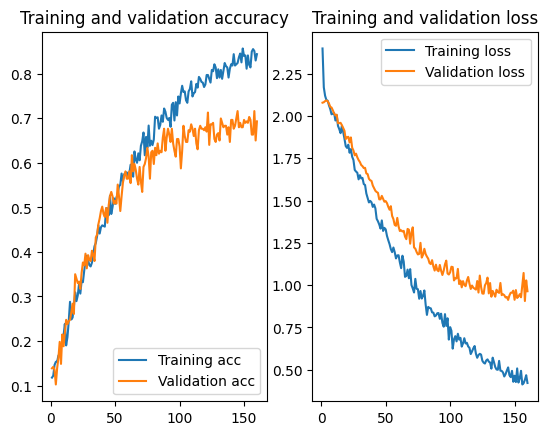

In [17]:
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)
# epochs = range(1, 76)

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()

plt.subplot(1, 2, 2)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.savefig('No_decay-160-2e-5-2.png')

# plt.fi
plt.show()

In [20]:
X_dev_frame_float32_test = np.load('../input/Video_data_test_10.npz', mmap_mode='r+')
X_dev_frame_float32_test['arr_0'].shape 

pickle_audio_mfcc_test = open("../input/Audio_data_test.pickle","rb")
X_dev_audio_mfcc_test = pickle.load(pickle_audio_mfcc_test)

pickle_y_dev_test = open("../input/Output_data_test.pickle","rb")
Y_dev_float32_test = pickle.load(pickle_y_dev_test)

In [21]:
Y_dev_float32_test = Y_dev_float32_test - 1

In [25]:
X_dev_audio_mfcc_test = X_dev_audio_mfcc_test[:, :, : -128]
X_dev_audio_mfcc_test.shape

(432, 100, 25)

In [23]:
Y_dev_float32_emotions_test = to_categorical(Y_dev_float32_test)   #keras.utils
# Y_dev_float32_sentiments = to_categorical(Y_dev_float32[:,1])

print(Y_dev_float32_emotions_test.shape)

(432, 8)


In [26]:
model.evaluate(x = [X_dev_frame_float32_test, X_dev_audio_mfcc_test], y = [Y_dev_float32_emotions_test], batch_size = 8)

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.6133 - loss: 1.1873


[1.0700169801712036, 0.6504629850387573]

In [22]:
X_dev_frame_float32_test = X_dev_frame_float32_test['arr_0'].astype("float64")
X_dev_frame_float32_test = X_dev_frame_float32_test / 255

In [ ]:
model

In [17]:
checkpoint

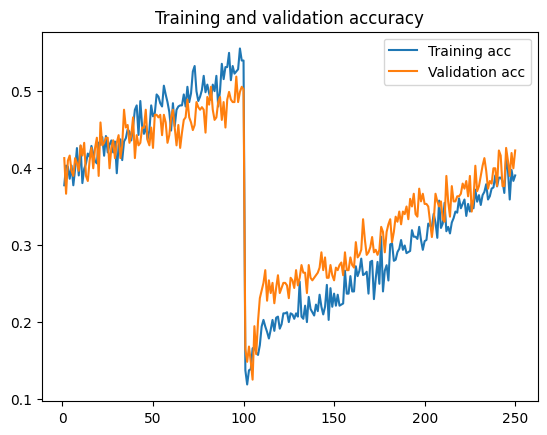

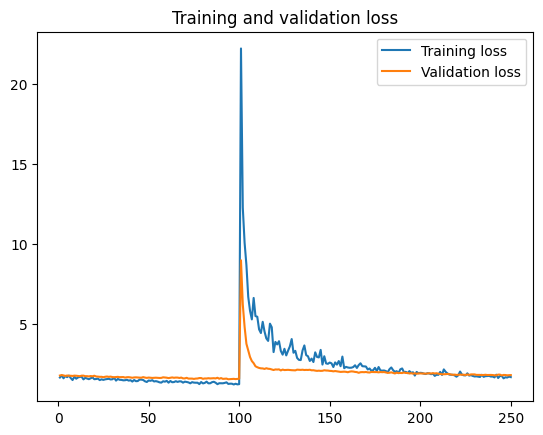

In [19]:
acc = history_.history['accuracy'] + acc
val_acc = history_.history['val_accuracy'] + val_acc
loss = history_.history['loss'] + loss
val_loss = history_.history['val_loss'] + val_loss

import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.savefig('No_decay-250.png')
plt.show()

In [15]:
optim

In [ ]:
1 + 1

In [1]:
tf.config.list_physical_devices('GPU')

NameError: name 'tf' is not defined

In [35]:
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
#Save history pickle